## STORE SALES TIMESERIES FORECAST

### TABLE OF CONTENTS

A. **Pace: Plan stage**

    1. Introduction: Definition of forecasting task with identification of features and target

B. **pAce: Analyze stage**

    2. Data Preparation
    3. Data Visualization
    4. Multistep forecasting strategies: multioutput, direct, recursive, DiRec

C. **paCe: Construct stage**

    5. Model Construction: Boosted Hybrid vs Stacked hybrid

D. **pacE: Execute stage**

    6. Hyperparameter tuning
    7. Conclusion

### A. Pace: Plan Stage

1. Introduction: Definition of forecasting task with identification of features and target
    In this section, we will define the forecasting task and identify the relevant features and target variable.

#### Introduction

This project aims to forecast store sales using a time series dataset from Kaggle. The primary goal is to predict future sales for each product family sold at Favorita stores located in Ecuador. Accurate forecasts can help in inventory management, staffing, and overall business strategy.


#### Identification of Features and Target

Features:
- Store ID
- Date
- Promotion
- Holiday
- Day of the week
- Season
- Weather

Target:
- Sales 

In [31]:
%%time

## Imports

# Installing select libraries

# General library imports
from gc import collect
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.display import clear_output

# Data manipulation and visualization
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Model and pipeline specifics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold, train_test_split

# Time series specific
from statsmodels.tsa.deterministic import DeterministicProcess

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Ensemble and tuning
import optuna
from optuna import create_study
optuna.logging.set_verbosity(optuna.logging.ERROR)

CPU times: total: 0 ns
Wall time: 5.01 ms


In [32]:
# Setting rc parameters in seaborn for plots and graphs
sns.set({"axes.facecolor": "#f7f9fc",
          "figure.facecolor": "#f7f9fc",
          "axes.edgecolor": "#000000",
          "grid.color": "#EBEBE7",
          "font.family": "serif",
          "axes.labelcolor": "#000000",
          "xtick.color": "#000000",
          "ytick.color": "#000000",
          "grid.alpha": 0.4,
         "grid.linewidth"       : 0.75,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        })

# Making sklearn pipeline outputs as dataframe
from sklearn import set_config
set_config(transform_output = "pandas")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format

print()
collect()

2155

### B. pAce: Analyze Stage

#### Data Preparation

In [33]:
## loading the sales by store dataset

store_sales = pd.read_csv(
    'data/train.csv',
    usecols=[
        'store_nbr', 'date', 'family', 'sales', 'onpromotion'
    ],
    dtype={
        'family': 'category',
        'store_nbr': 'category',
        'sales': 'float16', 
        'onpromotion': 'float16',
    }, 
    parse_dates=['date'],
    infer_datetime_format=True,
)

# Verify that all columns are loaded
print(store_sales.head())
print(store_sales.dtypes)

        date store_nbr      family  sales  onpromotion
0 2013-01-01         1  AUTOMOTIVE   0.00         0.00
1 2013-01-01         1   BABY CARE   0.00         0.00
2 2013-01-01         1      BEAUTY   0.00         0.00
3 2013-01-01         1   BEVERAGES   0.00         0.00
4 2013-01-01         1       BOOKS   0.00         0.00
date           datetime64[ns]
store_nbr            category
family               category
sales                 float16
onpromotion           float16
dtype: object


In [34]:
## this is an additional dataset containing the number of transactions that held each day;

store_transaction = pd.read_csv(
    'data/transactions.csv',
    usecols=[
        'date', 'store_nbr', 'transactions'
    ],
    dtype={
        'store_nbr': 'category',
        'transactions': 'float16', 
    }, 
    parse_dates=['date'],
    infer_datetime_format=True,
)

In [35]:
store_transaction = store_transaction.groupby(['date', 'store_nbr']).mean()

In [36]:
## merging the transaction and the sales per store dataset

sales_transaction_per_store = store_sales.merge(
    store_transaction,
    on=['date','store_nbr'],
    how='left'
)

# print(sales_transaction_per_store)

In [37]:
## loading the stores dataset

stores = pd.read_csv(
    'data/stores.csv',
    usecols=[
        'store_nbr', 'city', 'cluster'
    ],
    dtype={
        'store_nbr' : 'category',
        'city': 'category',
        'cluster': 'int64',
    },
)

In [38]:
## merged the sales and transactions per store dataset with the store dataset;

stores_added = sales_transaction_per_store.merge(
    stores, 
    on = 'store_nbr',
    how = 'left'
)

# print(stores_added)

In [39]:
## loaded the oil dataset with the existing dataset to assess the impact of oil
## on the sales among product families as Ecuador is an oil-producing country and its economy 
## depends heavily on it.

oil = pd.read_csv(
    'data/oil.csv',
    usecols=[
        'date', 'dcoilwtico'
    ],
    dtype={
        'dcoilwtico': 'float32', 
    }, 
    parse_dates=['date'],
    infer_datetime_format=True,
)

In [40]:
## next, we merge the dataset with the existing dataset;

oil_added = stores_added.merge(
    oil, 
    on = 'date',
    how = 'left'
)

# print(oil_added)

In [41]:
## loading the holidays dataset to see the effects of holidays on the sales of products;

holidays = pd.read_csv(
    'data/holidays_events.csv',
    usecols=[
        'date', 'type', 'locale', 'description', 'transferred'
    ],
    dtype={
        'type': 'category',
        'locale': 'category',
        'description' : 'category', 
        'transferred': 'bool', 
    }, 
    parse_dates=['date'],
    infer_datetime_format=True,
)

In [42]:
## merged the holidays dataset with the pre-existing dataset

holidays_added = oil_added.merge(
    holidays, 
    on = 'date',
    how = 'left'
)

# print(holidays_added)

In [43]:
## the final complex dataset;

store_sales_final = holidays_added

In [44]:
store_sales_final.dropna(inplace=True)

In [45]:
## extracting only recend sales from the years 2016 -2017

store_sales_final['date'] = store_sales_final.date.dt.to_period('D')
store_sales_final = store_sales_final.set_index(['store_nbr', 'family', 'date', 'city', 'locale', 'type', 'description']).sort_index()

family_sales = (
    store_sales_final.groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2016': '2017']
)

In [46]:
# Replace infinite values with NaN
family_sales.replace([np.inf, -np.inf], np.nan, inplace=True)

In [47]:
## Handling missing values by filling; once tried nearest neighbors filling - also known as interpolation

family_sales = family_sales.fillna(family_sales.mean())

In [48]:
## handling duplicate values by dropping them

family_sales = family_sales.drop_duplicates()

In [49]:
print(family_sales.head())

                sales                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2016-02-08       7.91      0.25   3.70  2,520.08  0.00       388.58   
2016-02-09       9.57      0.15   5.15  2,978.04  0.00       484.36   
2016-03-02       8.08      0.13   5.49  3,211.13  0.00       557.98   
2016-04-01       8.47      0.21   5.89  3,362.98  0.00       546.28   
2016-04-12       6.17      0.32   3.94  2,531.85  0.00       448.58   

                                                                             \
family     CELEBRATION CLEANING  DAIRY   DELI   EGGS FROZEN FOODS GROCERY I   
date                                                                          
2016-02-08       12.94   979.53 654.87 250.94 165.79       143.97  3,390.45   
2016-02-09       11.32 1,110.02 787.83 297.00 196.85       132.14  4,033.64   
2016-03-02       13.51 1,371.30 938.

In [50]:
# Dataset preprocessing for the model construction;

## Target series
y = family_sales.loc[:, 'sales']

# X_1: Features for Linear Model
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

# X_2: Features for Ensemble model
X_2 = family_sales.drop('sales', axis=1) # onpromotion feature, store feature, 

X_2 = pd.get_dummies(X_2, drop_first=True) #

In [51]:
# Define the cutoff date for the split
cutoff_date = '2017-01-31'

# Split the data based on the cutoff date
y_train = y.loc[:cutoff_date]
y_valid = y.loc[cutoff_date:]

X1_train = X_1.loc[:cutoff_date]
X1_valid = X_1.loc[cutoff_date:]

X2_train = X_2.loc[:cutoff_date]
X2_valid = X_2.loc[cutoff_date:]

### C. paCe: Construct Stage

In [52]:
# Define your model combinations
models_1 = [LinearRegression(), ElasticNet(), Lasso(), Ridge()]
models_2 = [RandomForestRegressor(), KNeighborsRegressor(), XGBRegressor()]

#### BoostedHybrid class creation

In [53]:
class boostedHybrid():
    def __init__(self, model_1, model_2): 
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_is_series = False  # To check if y is a Series or DataFrame
        self.y_columns = None  # To store the columns of y if it's a DataFrame
    
    def fit(self, X_1, X_2, y):
        # Check if y is a Series or DataFrame and handle accordingly
        if isinstance(y, pd.Series):
            self.y_is_series = True
            y = y.to_frame()
        
        # Save columns for later use in predict method
        self.y_columns = y.columns
        
        # Fit model_1
        self.model_1.fit(X_1, y)
        
        y_fit = pd.DataFrame(self.model_1.predict(X_1), index=X_1.index, columns=self.y_columns)

        # Compute residuals
        y_resid = y - y_fit

        # Fill NaNs in residuals
        y_resid.fillna(0, inplace=True)

        # Fit model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        return y_fit # this is so that we can plot the y fitted values on a graph
    
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(self.model_1.predict(X_1), index=X_1.index, columns=self.y_columns)
        
        # Predict residuals using model_2
        y_resid_pred = self.model_2.predict(X_2)
        
        # Ensure that y_resid_pred has the same shape as y_pred
        if len(y_pred.shape) == 1:
            y_resid_pred = pd.Series(y_resid_pred, index=X_1.index)
            y_pred = y_pred.add(y_resid_pred, axis=0)
        else:
            y_resid_pred = pd.DataFrame(y_resid_pred, index=X_1.index, columns=self.y_columns)
            y_pred = y_pred.add(y_resid_pred, axis=1)
        
        # If original y was a Series, return a Series
        if self.y_is_series:
            return y_pred.squeeze()
        
        return y_pred

### D. pacE: Execute stage

#### Model selection based on least root mean square logarithmic error;

In [54]:
# Initialize variables to store the best model and its RMSLE
best_model = None
best_rmsle = float('inf')
best_y_fit = None
best_y_pred = None

# Iterate through all combinations of model_1 and model_2
for model_1 in models_1:
    for model_2 in models_2:
        # Create the boosted hybrid model
        model = boostedHybrid(model_1, model_2)

        # Fit the model
        y_fit = model.fit(X_1, X_2, y)

        # Predict
        y_pred = model.predict(X_1, X_2)

        # Clip the predicted values and actual values to be non-negative
        y_pred_clipped = y_pred.clip(lower=0)
        y_clipped = y.clip(lower=0)

        # Calculate RMSLE
        rmsle_score = np.sqrt(mean_squared_log_error(y_clipped, y_pred_clipped))

        # Update the best model and its RMSLE if a better model is found
        if rmsle_score < best_rmsle:
            best_model = model
            best_rmsle = rmsle_score
            best_y_fit = y_fit
            best_y_pred = y_pred

# Print the best model and its RMSLE
print("Best Model:", best_model)
print("Best RMSLE:", best_rmsle)

Best Model: <__main__.boostedHybrid object at 0x000001A8B6C9D400>
Best RMSLE: 0.00013274763646160703


##### Best model is a combination of the Ridge and XGBoost as the linear and ensemble models respectively

In [55]:
best_model.model_1

Ridge()

In [56]:
best_model.model_2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Using the best model to forecast sales over the year 2017

In [57]:
best_model.fit(X1_train, X2_train, y_train)
y_fit = best_model.predict(X1_train, X2_train).clip(0.0)
y_pred = best_model.predict(X1_valid, X2_valid).clip(0.0)

#### Data Visualization 

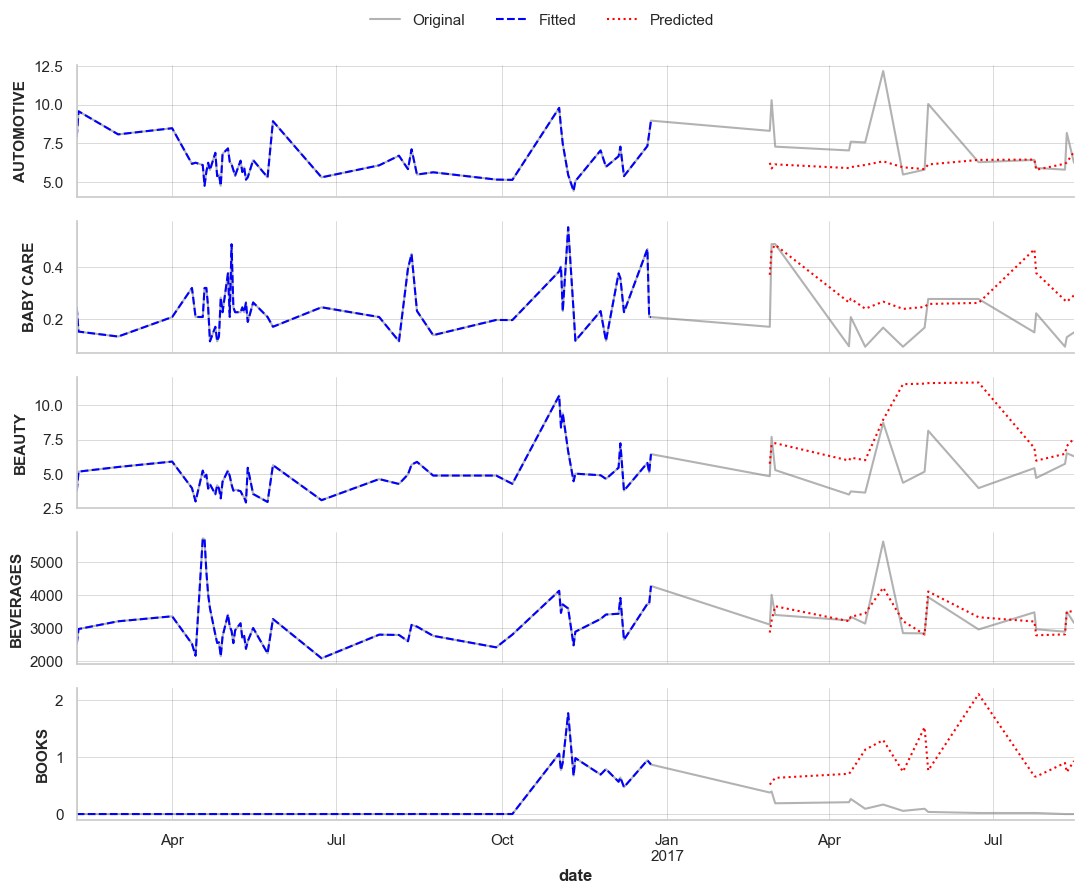

In [67]:
# Set Seaborn style for a clean and elegant look
sns.set(style="whitegrid")

# Select families
families = y.columns[0:5]

# Create subplots with adjusted spacing
fig, axs = plt.subplots(nrows=len(families), ncols=1, sharex=True, figsize=(11, 9))

# Define a custom color palette
colors = ['grey', 'blue', 'red']  # Grey for Original, Blue for Fitted, Red for Predicted

# Plot the data
for i, (ax, family) in enumerate(zip(axs, families)):
    # Plot the original data
    y[family].plot(ax=ax, alpha=0.6, linestyle='-', color=colors[0], label='Original')
    
    # Plot the fitted data
    y_fit[family].plot(ax=ax, color=colors[1], linestyle='--', label='Fitted')
    
    # Plot the predicted data
    y_pred[family].plot(ax=ax, color=colors[2], linestyle=':', label='Predicted')
    
    # Customize labels without titles
    ax.set_ylabel(family, fontsize=11)
    
    # Enhance grid and spines for a minimalist look
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='grey')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create a single legend outside the plot area
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, fontsize=11)

# Adjust layout to prevent overlap and provide space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

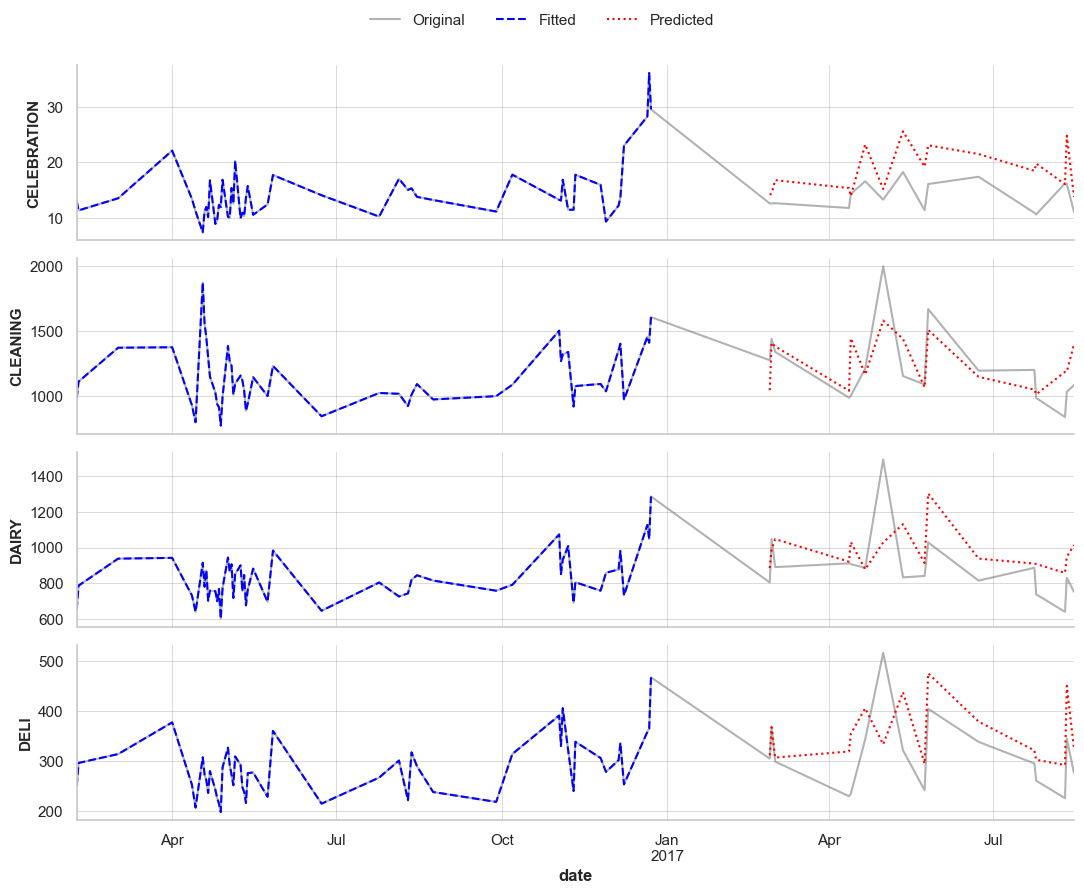

In [63]:
# Set Seaborn style for a clean and elegant look
sns.set(style="whitegrid")

# Select families
families = y.columns[6:10]

# Create subplots with adjusted spacing
fig, axs = plt.subplots(nrows=len(families), ncols=1, sharex=True, figsize=(11, 9))

# Define a custom color palette
colors = ['grey', 'blue', 'red']  # Grey for Original, Blue for Fitted, Red for Predicted

# Plot the data
for i, (ax, family) in enumerate(zip(axs, families)):
    # Plot the original data
    y[family].plot(ax=ax, alpha=0.6, linestyle='-', color=colors[0], label='Original')
    
    # Plot the fitted data
    y_fit[family].plot(ax=ax, color=colors[1], linestyle='--', label='Fitted')
    
    # Plot the predicted data
    y_pred[family].plot(ax=ax, color=colors[2], linestyle=':', label='Predicted')
    
    # Customize labels without titles
    ax.set_ylabel(family, fontsize=11)
    
    # Enhance grid and spines for a minimalist look
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='grey')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create a single legend outside the plot area
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, fontsize=11)

# Adjust layout to prevent overlap and provide space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

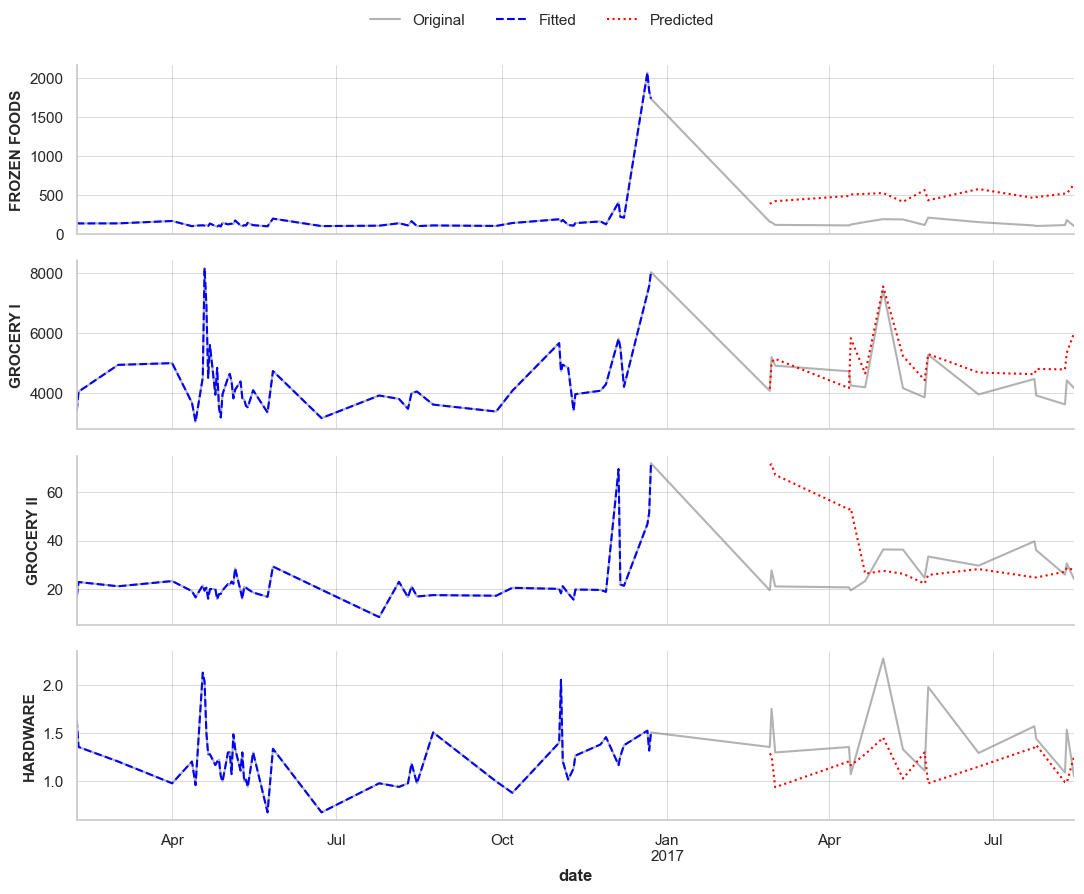

In [64]:
# Set Seaborn style for a clean and elegant look
sns.set(style="whitegrid")

# Select families
families = y.columns[11:15]

# Create subplots with adjusted spacing
fig, axs = plt.subplots(nrows=len(families), ncols=1, sharex=True, figsize=(11, 9))

# Define a custom color palette
colors = ['grey', 'blue', 'red']  # Grey for Original, Blue for Fitted, Red for Predicted

# Plot the data
for i, (ax, family) in enumerate(zip(axs, families)):
    # Plot the original data
    y[family].plot(ax=ax, alpha=0.6, linestyle='-', color=colors[0], label='Original')
    
    # Plot the fitted data
    y_fit[family].plot(ax=ax, color=colors[1], linestyle='--', label='Fitted')
    
    # Plot the predicted data
    y_pred[family].plot(ax=ax, color=colors[2], linestyle=':', label='Predicted')
    
    # Customize labels without titles
    ax.set_ylabel(family, fontsize=11)
    
    # Enhance grid and spines for a minimalist look
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='grey')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create a single legend outside the plot area
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, fontsize=11)

# Adjust layout to prevent overlap and provide space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

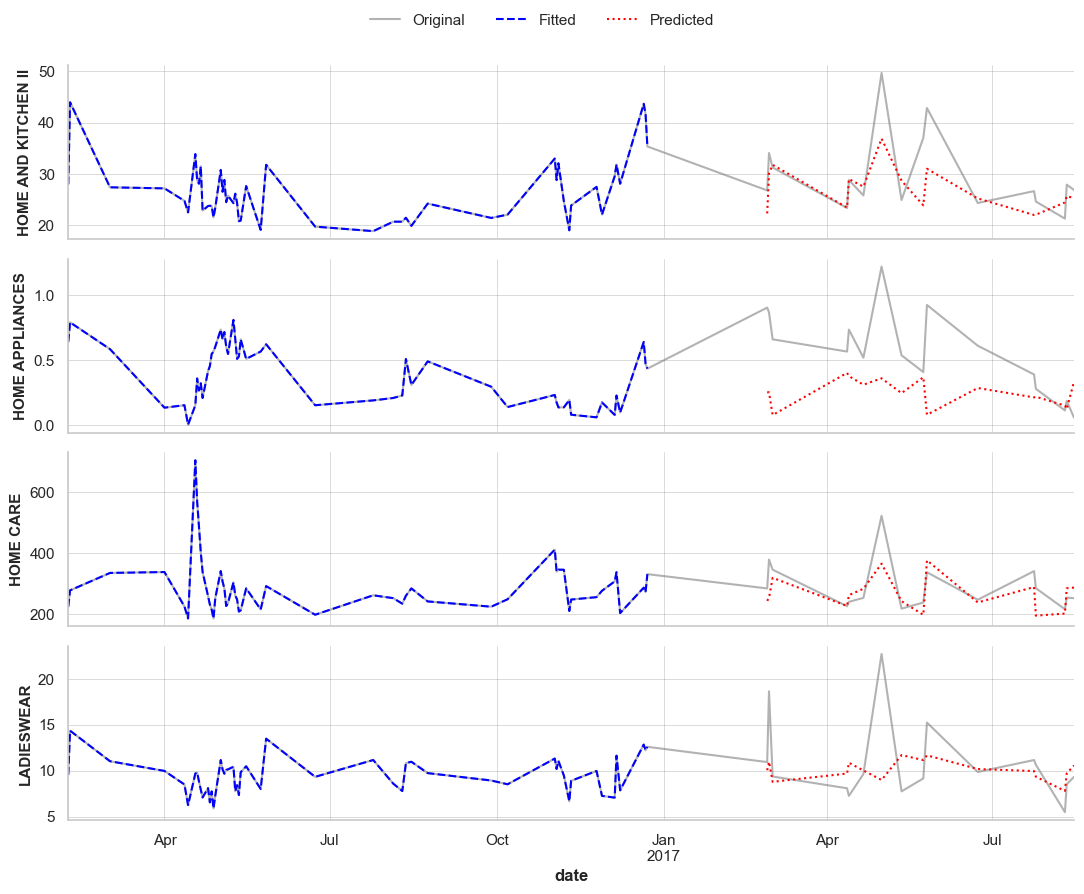

In [65]:
# Set Seaborn style for a clean and elegant look
sns.set(style="whitegrid")

# Select families
families = y.columns[16:20]

# Create subplots with adjusted spacing
fig, axs = plt.subplots(nrows=len(families), ncols=1, sharex=True, figsize=(11, 9))

# Define a custom color palette
colors = ['grey', 'blue', 'red']  # Grey for Original, Blue for Fitted, Red for Predicted

# Plot the data
for i, (ax, family) in enumerate(zip(axs, families)):
    # Plot the original data
    y[family].plot(ax=ax, alpha=0.6, linestyle='-', color=colors[0], label='Original')
    
    # Plot the fitted data
    y_fit[family].plot(ax=ax, color=colors[1], linestyle='--', label='Fitted')
    
    # Plot the predicted data
    y_pred[family].plot(ax=ax, color=colors[2], linestyle=':', label='Predicted')
    
    # Customize labels without titles
    ax.set_ylabel(family, fontsize=11)
    
    # Enhance grid and spines for a minimalist look
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='grey')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create a single legend outside the plot area
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, fontsize=11)

# Adjust layout to prevent overlap and provide space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

##### Thank you for staying through to the end. I'm Ikechukwu Ugbo, a final-year medical student, and researcher at the University of Ibadan and to you a data scientist analyst.